In [6]:
# === Shape Grammar Glyphs (FAST) ===
# Mesh -> voxel pseudo-SDF (EDT) -> watershed lobes -> ellipsoid tokens
# pip install numpy scipy scikit-image trimesh pandas

import os, json
import numpy as np
import pandas as pd
import trimesh
from trimesh import repair
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

# -----------------------------
# Mesh loading
# -----------------------------
def load_mesh(mesh_path):
    m = trimesh.load(mesh_path, force='mesh')
    if not isinstance(m, trimesh.Trimesh):
        if isinstance(m, trimesh.Scene) and len(m.geometry):
            m = trimesh.util.concatenate(tuple(m.geometry.values()))
        else:
            raise ValueError(f"Could not load a mesh from: {mesh_path}")
    repair.fill_holes(m)
    repair.fix_normals(m)
    return m

# -----------------------------
# FAST pseudo-SDF via voxelization + EDTs
# -----------------------------
def sdf_grid_fast_vox(mesh, grid_res=72, pad_frac=0.02, close_iters=1):
    """
    Create a fast 'pseudo-SDF' on a voxel grid:
      - voxelize mesh at pitch set by bbox / grid_res
      - sdf = outside_edt - inside_edt  (negative inside)
    Returns: sdf (Z,Y,X), xs, ys, zs
    """
    mins, maxs = mesh.bounds
    size = (maxs - mins)
    pad = pad_frac * float(np.linalg.norm(size))
    mins = mins - pad
    maxs = maxs + pad
    size = (maxs - mins)
    longest = float(size.max())
    pitch = max(longest / float(grid_res), 1e-6)

    vg = mesh.voxelized(pitch=pitch)
    # occupancy (Z,Y,X)
    if hasattr(vg, "matrix") and vg.matrix is not None:
        occ = vg.matrix.astype(bool)
        origin = getattr(vg, "origin", mins)
    else:
        occ = vg.encoding.dense.astype(bool)
        origin = mins

    occ = np.ascontiguousarray(occ)
    if close_iters and close_iters > 0:
        occ = ndi.binary_closing(occ, iterations=int(close_iters))

    inside = occ
    outside = ~inside
    in_dt  = ndi.distance_transform_edt(inside)
    out_dt = ndi.distance_transform_edt(outside)
    sdf = (out_dt - in_dt).astype(np.float32)

    nz, ny, nx = sdf.shape
    xs = origin[0] + np.arange(nx) * pitch
    ys = origin[1] + np.arange(ny) * pitch
    zs = origin[2] + np.arange(nz) * pitch
    return sdf, xs, ys, zs

# -----------------------------
# EDT watershed → lobe labels (fast + pruned)
# -----------------------------
def segment_lobes_fast(sdf, smooth_sigma=0.75, min_voxels=300, max_lobes=6,
                       peak_min_dist=3, peak_rel_thresh=0.25):
    """
    Speed tricks:
      - smooth inside mask lightly
      - use EDT peaks with peak_local_max (pruned & capped)
      - cap markers to ~2*max_lobes (largest by EDT value)
    """
    inside = sdf < 0
    if inside.sum() == 0:
        return None, None

    sm = ndi.gaussian_filter(inside.astype(np.float32), smooth_sigma) > 0.5
    dist = ndi.distance_transform_edt(sm)

    # find peaks (markers) with intensity threshold tied to max EDT
    dmax = float(dist.max())
    if dmax <= 0:
        return None, None
    thresh = peak_rel_thresh * dmax
    coords = peak_local_max(
        dist, labels=sm.astype(np.uint8),
        min_distance=peak_min_dist,
        threshold_abs=thresh,
        exclude_border=False
    )
    if coords.size == 0:
        return None, None

    # rank peaks by EDT value, keep at most 2*max_lobes
    vals = dist[tuple(coords.T)]
    order = np.argsort(-vals)
    keep_k = min(len(order), max_lobes * 2)
    coords = coords[order[:keep_k]]

    markers = np.zeros_like(dist, dtype=np.int32)
    for i, (z, y, x) in enumerate(coords, start=1):
        markers[z, y, x] = i

    labels = watershed(-dist, markers=markers, mask=sm)

    # keep big regions; relabel 1..K by size
    sizes = []
    for lab in range(1, labels.max() + 1):
        cnt = np.count_nonzero(labels == lab)
        if cnt >= min_voxels:
            sizes.append((lab, cnt))
    if not sizes:
        return None, None
    sizes.sort(key=lambda t: -t[1])
    sizes = sizes[:max_lobes]

    out = np.zeros_like(labels, dtype=np.int32)
    for new_id, (lab, _) in enumerate(sizes, start=1):
        out[labels == lab] = new_id
    kept_sizes = {new_id: np.count_nonzero(out == new_id) for new_id in range(1, out.max() + 1)}
    return out, kept_sizes

# -----------------------------
# Fit ellipsoid per lobe (center & axis lengths; orientation-free)
# -----------------------------
def fit_ellipsoid(world_pts):
    C = world_pts.mean(axis=0)
    P = world_pts - C
    cov = np.cov(P.T)
    vals, _ = np.linalg.eigh(cov)
    vals = np.clip(vals, 1e-9, None)
    axes = 2.0 * np.sqrt(vals)  # ~2*std (diameter proxy)
    axes.sort()
    a, b, c = axes[::-1]
    elong = a / (b + 1e-9)
    flat  = b / (c + 1e-9)
    return C, (a, b, c), elong, flat

def voxel_indices_to_world(idx_triplets, xs, ys, zs):
    zz, yy, xx = idx_triplets[:,0], idx_triplets[:,1], idx_triplets[:,2]
    return np.column_stack([xs[xx], ys[yy], zs[zz]])

# -----------------------------
# Build glyph tokens for one mesh
# -----------------------------
def glyph_for_mesh(mesh_path, label=None, out_dir="glyph_out",
                   grid_res=72, min_voxels=300, max_lobes=6,
                   smooth_sigma=0.75, peak_min_dist=3, peak_rel_thresh=0.25,
                   pad_frac=0.02, close_iters=1):
    os.makedirs(out_dir, exist_ok=True)
    label = label or os.path.basename(mesh_path).split('.')[0]

    mesh = load_mesh(mesh_path)
    sdf, xs, ys, zs = sdf_grid_fast_vox(mesh, grid_res=grid_res, pad_frac=pad_frac, close_iters=close_iters)

    labels, sizes = segment_lobes_fast(
        sdf, smooth_sigma=smooth_sigma, min_voxels=min_voxels, max_lobes=max_lobes,
        peak_min_dist=peak_min_dist, peak_rel_thresh=peak_rel_thresh
    )
    if labels is None:
        out = {"label": label, "n_lobes": 0, "glyph_string": "L0: -", "tokens": []}
        with open(os.path.join(out_dir, f"{label}_glyph.json"), "w") as f:
            json.dump(out, f, indent=2)
        return out

    lobes = sorted(sizes.items(), key=lambda x: -x[1])  # by voxel count
    tokens = []
    for rank, (lid, count) in enumerate(lobes, start=1):
        idx = np.argwhere(labels == lid)
        pts = voxel_indices_to_world(idx, xs, ys, zs)
        C, (a,b,c), elong, flat = fit_ellipsoid(pts)
        tokens.append({
            "rank": rank,
            "voxel_count": int(count),
            "center": [float(C[0]), float(C[1]), float(C[2])],
            "axes": [float(a), float(b), float(c)],
            "elongation": float(elong),
            "flatness": float(flat)
        })

    parts = [
        f"E{t['rank']}[{t['axes'][0]:.1f},{t['axes'][1]:.1f},{t['axes'][2]:.1f}]@"
        f"[{t['center'][0]:.1f},{t['center'][1]:.1f},{t['center'][2]:.1f}]"
        for t in tokens
    ]
    glyph_string = f"L{len(tokens)}: " + "; ".join(parts)

    out = {"label": label, "n_lobes": len(tokens), "glyph_string": glyph_string, "tokens": tokens}
    with open(os.path.join(out_dir, f"{label}_glyph.json"), "w") as f:
        json.dump(out, f, indent=2)
    return out

# -----------------------------
# Batch over meshes → CSV summary
# -----------------------------
def glyphs_for_meshes(mesh_paths, labels=None, out_dir="glyph_out",
                      grid_res=72, min_voxels=300, max_lobes=6,
                      smooth_sigma=0.75, peak_min_dist=3, peak_rel_thresh=0.25,
                      pad_frac=0.02, close_iters=1):
    labels = labels or [os.path.basename(p).split('.')[0] for p in mesh_paths]
    records, all_json = [], []
    for p, lab in zip(mesh_paths, labels):
        print(f"[Glyph FAST] {lab} ...")
        res = glyph_for_mesh(
            p, label=lab, out_dir=out_dir,
            grid_res=grid_res, min_voxels=min_voxels, max_lobes=max_lobes,
            smooth_sigma=smooth_sigma, peak_min_dist=peak_min_dist, peak_rel_thresh=peak_rel_thresh,
            pad_frac=pad_frac, close_iters=close_iters
        )
        all_json.append(res)
        row = {"label": res["label"], "n_lobes": res["n_lobes"], "glyph_string": res["glyph_string"]}
        for i, t in enumerate(res["tokens"][:3], start=1):
            row[f"E{i}_a"] = t["axes"][0]; row[f"E{i}_b"] = t["axes"][1]; row[f"E{i}_c"] = t["axes"][2]
            row[f"E{i}_elong"] = t["elongation"]; row[f"E{i}_flat"] = t["flatness"]
        records.append(row)
    df = pd.DataFrame.from_records(records)
    os.makedirs(out_dir, exist_ok=True)
    csv_path = os.path.join(out_dir, "shape_grammar_glyphs.csv")
    df.to_csv(csv_path, index=False)
    print("Saved:", csv_path)
    return df, all_json

# -----------------------------
# Example
# -----------------------------
mesh_paths = [
    "data/green_monkey/all_structure_files/chr1/spatial_data/overall_shapes/chr1_12hrs_vacv_metaball.obj",
    "data/green_monkey/all_structure_files/chr1/spatial_data/overall_shapes/chr1_18hrs_vacv_metaball.obj",
    "data/green_monkey/all_structure_files/chr1/spatial_data/overall_shapes/chr1_24hrs_vacv_metaball.obj",
]
labels = ["12h vacv", "18h vacv", "24h vacv"]

df, glyph_json = glyphs_for_meshes(
    mesh_paths, labels=labels, out_dir="data/green_monkey/va_testing/glyph_plots",
    grid_res=72,          # try 64–96
    min_voxels=400,       # raise to merge speckles; lower to split more
    max_lobes=6,
    smooth_sigma=0.75,    # small smoothing for stability
    peak_min_dist=3,      # fewer markers = faster
    peak_rel_thresh=0.25, # ignore weak peaks (<25% of max EDT)
    pad_frac=0.02,
    close_iters=1
)

print(df[["label","n_lobes","glyph_string"]])


[Glyph FAST] 12h vacv ...
[Glyph FAST] 18h vacv ...
[Glyph FAST] 24h vacv ...
Saved: data/green_monkey/va_testing/glyph_plots/shape_grammar_glyphs.csv
      label  n_lobes                                       glyph_string
0  12h vacv        6  L6: E1[3.6,3.0,2.8]@[-41.9,14.1,-69.1]; E2[4.0...
1  18h vacv        6  L6: E1[3.4,3.2,2.5]@[29.0,7.5,67.0]; E2[2.9,2....
2  24h vacv        6  L6: E1[3.9,2.2,1.9]@[25.1,96.3,-12.8]; E2[3.0,...


In [7]:
df.head()

,label,n_lobes,glyph_string,E1_a,E1_b,E1_c,E1_elong,E1_flat,E2_a,E2_b,E2_c,E2_elong,E2_flat,E3_a,E3_b,E3_c,E3_elong,E3_flat
0,12h vacv,6,"L6: E1[3.6,3.0,2.8]@[-41.9,14.1,-69.1]; E2[4.0...",3.581554,3.040656,2.807885,1.177889,1.082899,4.041847,2.323568,1.674817,1.739500,1.387357,3.283273,2.354118,1.275125,1.394693,1.846187
1,18h vacv,6,"L6: E1[3.4,3.2,2.5]@[29.0,7.5,67.0]; E2[2.9,2....",3.425136,3.179794,2.490936,1.077156,1.276546,2.866872,2.561048,1.571239,1.119414,1.629955,3.105391,2.674950,1.207765,1.160916,2.214793
2,24h vacv,6,"L6: E1[3.9,2.2,1.9]@[25.1,96.3,-12.8]; E2[3.0,...",3.888046,2.231280,1.890847,1.742518,1.180043,3.028767,2.344356,1.774177,1.291940,1.321377,3.516858,2.197575,1.626099,1.600336,1.351440


/var/folders/29/w54hnxjs18q9cvq1pfzwym540000gn/T/ipykernel_7909/1291396603.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Saved: data/green_monkey/va_testing/glyph_plots/glyphs_with_comparisons.png


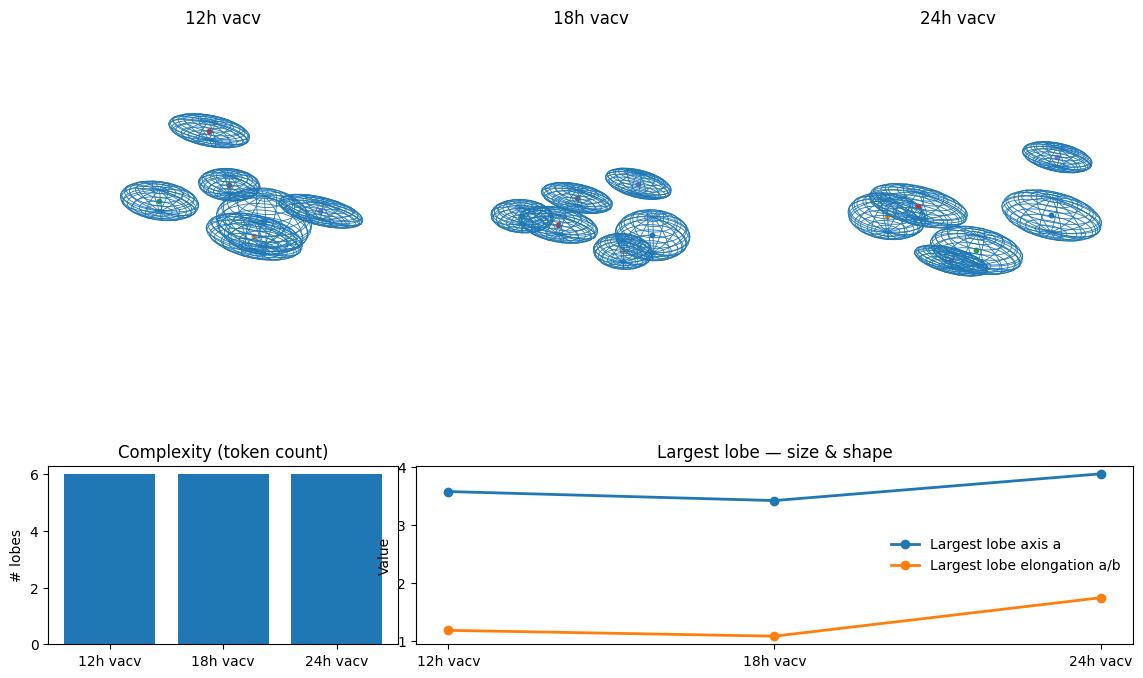

In [8]:
import os, numpy as np, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from matplotlib.gridspec import GridSpec

# --- helpers reused ---
def _set_equal_3d(ax, X, Y, Z, pad=0.05):
    xmin, xmax = np.min(X), np.max(X)
    ymin, ymax = np.min(Y), np.max(Y)
    zmin, zmax = np.min(Z), np.max(Z)
    cx, cy, cz = (xmax+xmin)/2, (ymax+ymin)/2, (zmax+zmin)/2
    r = max(xmax-xmin, ymax-ymin, zmax-zmin) * (0.5 + pad)
    ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)

def _plot_ellipsoid(ax, center, axes, n=30, lw=0.6):
    a, b, c = [x/2.0 for x in axes]
    u = np.linspace(0, 2*np.pi, n)
    v = np.linspace(0, np.pi, n)
    x = a * np.outer(np.cos(u), np.sin(v)) + center[0]
    y = b * np.outer(np.sin(u), np.sin(v)) + center[1]
    z = c * np.outer(np.ones_like(u), np.cos(v)) + center[2]
    ax.plot_wireframe(x, y, z, rstride=2, cstride=2, linewidth=lw)
    ax.scatter([center[0]], [center[1]], [center[2]], s=10)

# --- build figure ---
out_dir = "data/green_monkey/va_testing/glyph_plots"
os.makedirs(out_dir, exist_ok=True)

labels = [g["label"] for g in glyph_json]
# metrics for bottom row
n_lobes = [g["n_lobes"] for g in glyph_json]
# take largest lobe (rank=1) if present
largest_a = []
largest_elong = []
for g in glyph_json:
    if g["tokens"]:
        t1 = sorted(g["tokens"], key=lambda t: t["rank"])[0]
        largest_a.append(t1["axes"][0])          # you can switch to 1 or 2 for b/c
        largest_elong.append(t1["elongation"])
    else:
        largest_a.append(np.nan)
        largest_elong.append(np.nan)

fig = plt.figure(figsize=(14, 8))
gs = GridSpec(2, len(glyph_json), height_ratios=[2.0, 1.0], hspace=0.3, wspace=0.05)

# ---- Top row: side-by-side 3D glyphs ----
for i, g in enumerate(glyph_json):
    ax = fig.add_subplot(gs[0, i], projection='3d')
    ax.set_title(g["label"])
    tokens = g["tokens"]
    if not tokens:
        ax.text2D(0.1, 0.9, "No lobes", transform=ax.transAxes)
        ax.set_axis_off()
        continue
    cx, cy, cz = [], [], []
    for t in tokens:
        _plot_ellipsoid(ax, t["center"], t["axes"], lw=0.6)
        cx.append(t["center"][0]); cy.append(t["center"][1]); cz.append(t["center"][2])
    _set_equal_3d(ax, np.array(cx), np.array(cy), np.array(cz), pad=0.15)
    ax.set_axis_off()

# ---- Bottom left: lobe count per timepoint ----
ax1 = fig.add_subplot(gs[1, :len(glyph_json)//2 or 1])
x = np.arange(len(labels))
ax1.bar(x, n_lobes)
ax1.set_xticks(x); ax1.set_xticklabels(labels, rotation=0)
ax1.set_ylabel("# lobes")
ax1.set_title("Complexity (token count)")

# ---- Bottom right: largest-lobe size & shape vs time ----
ax2 = fig.add_subplot(gs[1, len(glyph_json)//2 or 1:])
ax2.plot(labels, largest_a, marker="o", linewidth=2, label="Largest lobe axis a")
ax2.plot(labels, largest_elong, marker="o", linewidth=2, label="Largest lobe elongation a/b")
ax2.set_title("Largest lobe — size & shape")
ax2.legend(frameon=False)
ax2.set_ylabel("Value")

panel_path = os.path.join(out_dir, "glyphs_with_comparisons.png")
fig.tight_layout()
fig.savefig(panel_path, dpi=150)
print("Saved:", panel_path)

# --- If you’d rather compare by rank across time (top-3 lobes), swap the bottom-right with this:
# ranks_to_show = [1,2,3]
# ax2.clear(); ax2.set_title("Axis a by lobe rank")
# for r in ranks_to_show:
#     vals = []
#     for g in glyph_json:
#         tok = next((t for t in g["tokens"] if t["rank"] == r), None)
#         vals.append(tok["axes"][0] if tok else np.nan)
#     ax2.plot(labels, vals, marker="o", linewidth=2, label=f"E{r}.a")
# ax2.legend(frameon=False); ax2.set_ylabel("Axis a")
# fig.tight_layout(); fig.savefig(panel_path, dpi=150); print("Saved:", panel_path)


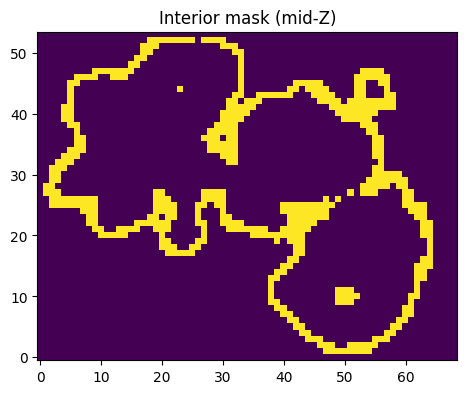

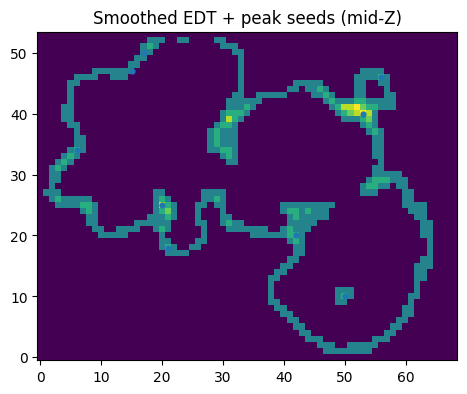

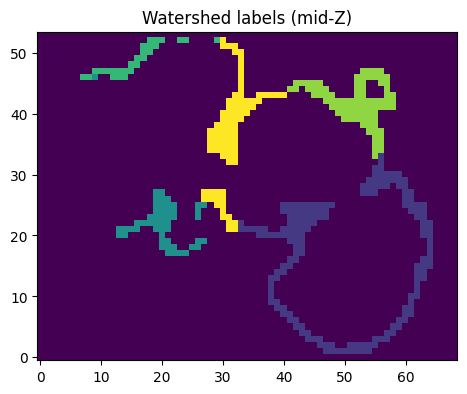

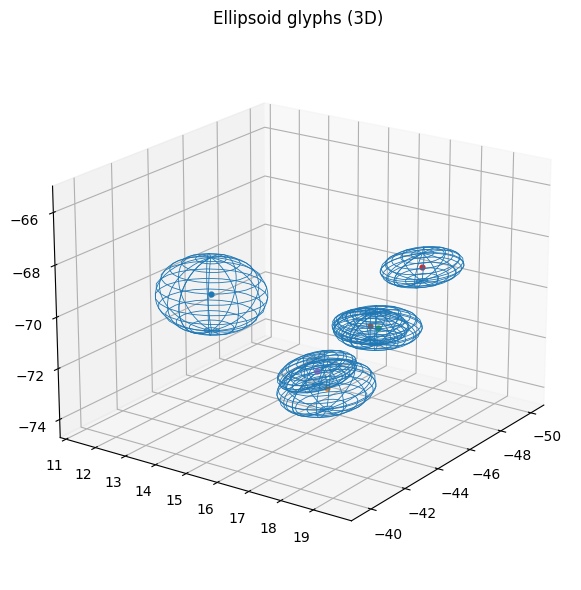

In [13]:
# === Lobe-extraction walkthrough on YOUR mesh (display only) ===
# Shows: (1) interior mask mid-slice, (2) smoothed EDT + seeds, 
#        (3) watershed labels, (4) 3D ellipsoid glyphs for lobes.

import numpy as np, matplotlib.pyplot as plt, trimesh
from trimesh import repair
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ---------- FAST voxel pseudo-SDF (negative inside) ----------
def sdf_grid_fast_vox(mesh, grid_res=72, pad_frac=0.02, close_iters=1):
    mins, maxs = mesh.bounds
    size = (maxs - mins)
    pad = pad_frac * float(np.linalg.norm(size))
    mins = mins - pad; maxs = maxs + pad
    longest = float((maxs - mins).max())
    pitch = max(longest / float(grid_res), 1e-6)

    vg = mesh.voxelized(pitch=pitch)
    if hasattr(vg, "matrix") and vg.matrix is not None:
        occ = vg.matrix.astype(bool)
        origin = getattr(vg, "origin", mins)
    else:
        occ = vg.encoding.dense.astype(bool)
        origin = mins

    if close_iters and close_iters > 0:
        occ = ndi.binary_closing(occ, iterations=int(close_iters))

    inside = occ
    outside = ~inside
    in_dt  = ndi.distance_transform_edt(inside)
    out_dt = ndi.distance_transform_edt(outside)
    sdf = (out_dt - in_dt).astype(np.float32)  # negative inside

    nz, ny, nx = sdf.shape
    xs = origin[0] + np.arange(nx) * pitch
    ys = origin[1] + np.arange(ny) * pitch
    zs = origin[2] + np.arange(nz) * pitch
    return sdf, xs, ys, zs

# ---------- Segment lobes (same logic as your pipeline, trimmed) ----------
def segment_lobes(sdf, smooth_sigma=0.75, min_voxels=400, peak_min_dist=3, peak_rel_thresh=0.25, max_lobes=6):
    inside = sdf < 0
    if inside.sum() == 0:
        return None, None, None
    sm = ndi.gaussian_filter(inside.astype(np.float32), smooth_sigma) > 0.5
    dist = ndi.distance_transform_edt(sm)

    dmax = float(dist.max())
    if dmax <= 0:
        return None, None, None
    coords = peak_local_max(
        dist, labels=sm.astype(np.uint8),
        min_distance=peak_min_dist,
        threshold_rel=peak_rel_thresh,  # keep strong peaks only
        exclude_border=False
    )
    if coords.size == 0:
        return None, None, None

    # Keep strongest markers; cap to ~2*max_lobes
    vals = dist[tuple(coords.T)]
    order = np.argsort(-vals)
    coords = coords[order[:max_lobes*2]]

    markers = np.zeros_like(dist, dtype=np.int32)
    for i, (z,y,x) in enumerate(coords, start=1):
        markers[z,y,x] = i

    labels = watershed(-dist, markers=markers, mask=sm)

    # filter tiny regions; relabel 1..K by size
    sizes = []
    for lab in range(1, labels.max()+1):
        cnt = np.count_nonzero(labels == lab)
        if cnt >= min_voxels:
            sizes.append((lab, cnt))
    if not sizes:
        return inside, dist, None
    sizes.sort(key=lambda t: -t[1])
    sizes = sizes[:max_lobes]
    relabeled = np.zeros_like(labels, dtype=np.int32)
    for new_id, (lab, _) in enumerate(sizes, start=1):
        relabeled[labels == lab] = new_id
    return inside, dist, relabeled

# ---------- Fit & plot ellipsoids ----------
def fit_ellipsoid(points):
    C = points.mean(axis=0)
    P = points - C
    vals, _ = np.linalg.eigh(np.cov(P.T))
    vals = np.clip(vals, 1e-9, None)
    axes = 2.0 * np.sqrt(vals); axes.sort()
    a,b,c = axes[::-1]
    return C, (a,b,c)

def plot_ellipsoid(ax, center, axes, n=24, lw=0.6):
    a,b,c = [v/2.0 for v in axes]
    u = np.linspace(0, 2*np.pi, n)
    v = np.linspace(0, np.pi, n)
    Xs = a * np.outer(np.cos(u), np.sin(v)) + center[0]
    Ys = b * np.outer(np.sin(u), np.sin(v)) + center[1]
    Zs = c * np.outer(np.ones_like(u), np.cos(v)) + center[2]
    ax.plot_wireframe(Xs, Ys, Zs, rstride=2, cstride=2, linewidth=lw)
    ax.scatter([center[0]],[center[1]],[center[2]], s=12)

# ---------- One-call visualizer ----------
def visualize_lobes_for_mesh(mesh_path, grid_res=72, min_voxels=400, max_lobes=6,
                             smooth_sigma=0.75, peak_min_dist=3, peak_rel_thresh=0.25,
                             pad_frac=0.02, close_iters=1):
    # load mesh
    m = trimesh.load(mesh_path, force='mesh')
    if not isinstance(m, trimesh.Trimesh) and hasattr(m, "geometry"):
        m = trimesh.util.concatenate(tuple(m.geometry.values()))
    repair.fill_holes(m); repair.fix_normals(m)

    # field + segmentation
    sdf, xs, ys, zs = sdf_grid_fast_vox(m, grid_res=grid_res, pad_frac=pad_frac, close_iters=close_iters)
    inside, dist, labels = segment_lobes(sdf, smooth_sigma, min_voxels, peak_min_dist, peak_rel_thresh, max_lobes)

    # 1) interior mask (mid-Z slice)
    mid = sdf.shape[0]//2
    plt.figure(figsize=(5,4))
    plt.imshow(inside[mid].astype(float), origin='lower')
    plt.title("Interior mask (mid-Z)")
    plt.tight_layout(); plt.show()

    # 2) smoothed EDT + seed markers (mid-Z)
    plt.figure(figsize=(5,4))
    plt.imshow(dist[mid], origin='lower')
    # re-find peaks just for display
    coords = peak_local_max(dist, labels=inside.astype(np.uint8),
                            min_distance=peak_min_dist, threshold_rel=peak_rel_thresh)
    pts = coords[coords[:,0]==mid]
    if len(pts)>0:
        plt.scatter(pts[:,2], pts[:,1], s=12)
    plt.title("Smoothed EDT + peak seeds (mid-Z)")
    plt.tight_layout(); plt.show()

    # 3) watershed labels (mid-Z)
    plt.figure(figsize=(5,4))
    if labels is None:
        plt.imshow(np.zeros_like(inside[mid]), origin='lower'); plt.title("No lobes found")
    else:
        plt.imshow(labels[mid], origin='lower'); plt.title("Watershed labels (mid-Z)")
    plt.tight_layout(); plt.show()

    # 4) 3D ellipsoid glyphs
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d'); ax.set_title("Ellipsoid glyphs (3D)")
    if labels is not None and labels.max()>0:
        for lid in range(1, labels.max()+1):
            idx = np.argwhere(labels==lid)
            if len(idx) < min_voxels:  # skip tiny region by the same rule
                continue
            pts = np.column_stack([xs[idx[:,2]], ys[idx[:,1]], zs[idx[:,0]]])  # (x,y,z)
            C, axes = fit_ellipsoid(pts)
            plot_ellipsoid(ax, C, axes)
        # set view box from all points used
        allz, ally, allx = np.where(inside)
        ax.set_xlim(xs.min(), xs.max()); ax.set_ylim(ys.min(), ys.max()); ax.set_zlim(zs.min(), zs.max())
    else:
        ax.text2D(0.1, 0.9, "No lobes", transform=ax.transAxes)
    ax.view_init(elev=20, azim=35)
    plt.tight_layout(); plt.show()

# ---------- Run on one of your meshes ----------
# Pick an index: 0 -> 12h, 1 -> 18h, 2 -> 24h (based on your mesh_paths order)
mesh_idx = 0
visualize_lobes_for_mesh(mesh_paths[mesh_idx], grid_res=72, min_voxels=400, max_lobes=6)
